## RL algorithms

In [34]:
import gym

import time
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

import matplotlib.pyplot as plt
plt.rcParams["font.size"] = 14

#### RL algorithms

- We used the PPO algorithm for almost the entire course (except offline RL)
- In fact, RLlib offers many algorithms! See [here](https://docs.ray.io/en/latest/rllib/rllib-algorithms.html).
- Let's look at one more algorithm, DQN.

Notes:

There are over 20 algorithms at the time of recording.

#### Deep Q-Network (DQN)

- DQN is famous in the RL world for many breakthroughs such as the [Atari results](https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf) from 2013.
- In RLlib, we only need to make the smallest of swaps:

PPO:

In [4]:
from ray.rllib.algorithms.ppo import PPOConfig

ppo = PPOConfig().framework("torch").build(env="FrozenLake-v1")

DQN:

In [5]:
from ray.rllib.algorithms.dqn import DQNConfig

dqn = DQNConfig().framework("torch").build(env="FrozenLake-v1")

2022-07-31 08:14:37,340	WARNING deprecation.py:47 -- DeprecationWarning: `ray.rllib.algorithms.dqn.dqn.DEFAULT_CONFIG` has been deprecated. Use `ray.rllib.algorithms.dqn.dqn.DQNConfig(...)` instead. This will raise an error in the future!
2022-07-31 08:14:37,342	WARNING deprecation.py:47 -- DeprecationWarning: `config['multiagent']['replay_mode']` has been deprecated. config['replay_buffer_config']['replay_mode'] This will raise an error in the future!


And that's it!

#### Using a DQN

In [6]:
t = time.time()
ppo_results = []
for i in range(8):
    ppo_results.append( ppo.train()["episode_reward_mean"] )
print(f"Elapsed time {time.time()-t:.1f} s")

(RolloutWorker pid=13332) 2022-07-31 09:00:18,276	WARNING deprecation.py:47 -- DeprecationWarning: `concat_samples` has been deprecated. Use `concat_samples() from rllib.policy.sample_batch` instead. This will raise an error in the future!
2022-07-31 09:00:19,156	WARNING deprecation.py:47 -- DeprecationWarning: `concat_samples` has been deprecated. Use `concat_samples() from rllib.policy.sample_batch` instead. This will raise an error in the future!


In [10]:
t = time.time()
dqn_results = []
for i in range(8):
    dqn_results.append( dqn.train()["episode_reward_mean"] )
print(f"Elapsed time {time.time()-t:.1f} s")

2022-07-31 09:01:36,089	WARNING deprecation.py:47 -- DeprecationWarning: `ReplayBuffer.add_batch()` has been deprecated. Use `ReplayBuffer.add()` instead. This will raise an error in the future!
2022-07-31 09:01:36,100	WARNING multi_agent_prioritized_replay_buffer.py:211 -- Adding batches with column `weights` to this buffer while providing weights as a call argument to the add method results in the column being overwritten.


ValueError: Invalid format specifier

#### Training

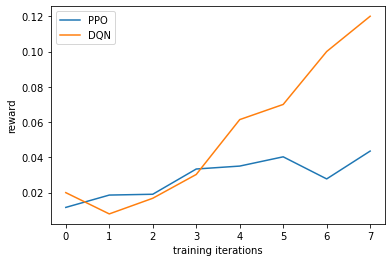

In [19]:
plt.plot(ppo_results, label="PPO")
plt.plot(dqn_results, label="DQN")
plt.legend();
plt.xlabel("training iterations");
plt.ylabel("reward");

- In this particular run of this case, DQN learns faster.
- But, like anything in ML, the answer is: "it depends".

#### Under the hood

- Under the hood PPO and DQN work very differently
- PPO is an **on-policy** algorithm, DQN is **off-policy**
- They also have similarities, e.g. both are _model-free_ methods

Notes:

- PPO trains while running its own policy
- DQN can train on _experiences_ that may come from another policy (related to offline RL)
- DQN learns like offline RL (from data) but it is always generating new data from the env

#### Q-values

- One big difference is that DQN directly learns _Q-values_
- What are these?

In [25]:
model = dqn.get_policy().model

In [37]:
from ray.rllib.models.preprocessors import get_preprocessor 
import torch

In [35]:
env = gym.make("FrozenLake-v1")

In [39]:
prep = get_preprocessor(env.observation_space)(env.observation_space)
model_out = model({"obs": torch.from_numpy(prep.transform(5)[None])})[0]

In [41]:
model.get_q_value_distributions(model_out)[0]

tensor([[0.1166, 0.0269, 0.0571, 0.0180]], grad_fn=<AddmmBackward0>)

In [48]:
float(model.get_state_value(model_out))

0.029845546931028366

In [99]:
q_s = [float(model.get_state_value(model({"obs": torch.from_numpy(prep.transform(i)[None])})[0])) for i in range(16)]

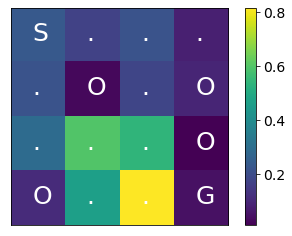

In [84]:
import numpy as np
plt.imshow(np.reshape(q_s, (4,4)));
plt.colorbar();
plt.xticks(());
plt.yticks(());
desc = [[c.decode("utf-8") for c in line] for line in env.desc.tolist()]
mapper = {"F" : ".", "H" : "O", "S" : "S", "G" : "G"}
for i in range(4):
    for j in range(4):
        plt.text(j-0.1,i+0.1, mapper[desc[i][j]], fontsize=25, color="white")

In [95]:
q_sa = np.array([model.get_q_value_distributions(model({"obs": torch.from_numpy(prep.transform(i)[None])})[0])[0].detach().numpy()[0] for i in range(16)])

In [107]:
# https://stackoverflow.com/questions/44666679/something-like-plt-matshow-but-with-triangles
def quatromatrix(left, bottom, right, top, ax=None, triplotkw={},tripcolorkw={}):
    if not ax: ax=plt.gca()
    n = left.shape[0]; m=left.shape[1]

    a = np.array([[0,0],[0,1],[.5,.5],[1,0],[1,1]])
    tr = np.array([[0,1,2], [0,2,3],[2,3,4],[1,2,4]])

    A = np.zeros((n*m*5,2))
    Tr = np.zeros((n*m*4,3))

    for i in range(n):
        for j in range(m):
            k = i*m+j
            A[k*5:(k+1)*5,:] = np.c_[a[:,0]+j, a[:,1]+i]
            Tr[k*4:(k+1)*4,:] = tr + k*5

    C = np.c_[ left.flatten(), bottom.flatten(), 
              right.flatten(), top.flatten()   ].flatten()

    triplot = ax.triplot(A[:,0], A[:,1], Tr, **triplotkw)
    tripcolor = ax.tripcolor(A[:,0], A[:,1], Tr, facecolors=C, **tripcolorkw)
    # return tripcolor
    return ax

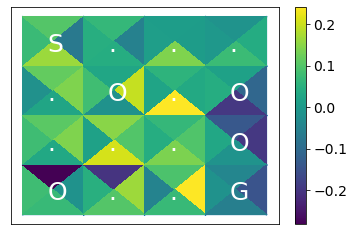

In [124]:
import matplotlib as mpl

ax = quatromatrix(q_sa[:4], q_sa[4:8], q_sa[8:12], q_sa[12:16])
ax.set_xticks(());
ax.set_yticks(());
ax.invert_yaxis();
for i in range(4):
    for j in range(4):
        plt.text(j+0.4,i+0.7, mapper[desc[i][j]], fontsize=25, color="white")
# fig = plt.gcf()

norm = mpl.colors.Normalize(vmin=q_sa.min(), vmax=q_sa.max())
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap='viridis'), ax=ax);

#### Q-values

#### Beyond DQN

#### Let's apply what we learned!

## MCQ
<!-- multiple choice -->

on off policy

- [ ] lr
- [ ] train_batch_size
- [ ] num_sgd_iter
- [x] entropy_coeff